<a href="https://colab.research.google.com/github/SumedhaSinghRathor/Deep-Learning-Powered-ResNet/blob/main/Deep_Learning_Powered_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
#importing necessary modules

import os
import cv2
# import keras # Keras is now part of TensorFlow
import numpy as np
import pandas as pd
import random as rn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import SVG
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Import from keras.optimizers instead of tensorflow.python.keras.optimizers
from tensorflow.keras.optimizers import Adam, RMSprop
# from tensorflow.pyhton.keras.utils import to_categorical # Typo, should be python
from tensorflow.keras.utils import to_categorical
# from tensorflow.python.kers.callbacks import ReduceLROnPlateau # Typo, should be keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, Conv2D, MaxPool2D

In [53]:
def DATASET_LOADER(DIR, RESIZE):
  IMG = []
  read = lambda imname: np.array(Image.open(imname).convert("RGB"))
  for IMAGE_NAME in tqdm(os.listdir(DIR)):
    PATH = os.path.join(DIR,IMAGE_NAME)
    _, ftype = os.path.splitext(PATH)
    if ftype == ".jpg":
      img = read(PATH)
      img = cv2.resize(img, (RESIZE, RESIZE))
      IMG.append(np.array(img)/255)
  return IMG

benign_train = np.array(DATASET_LOADER('/content/sample_data/train4/benign', 224))
malignant_train = np.array(DATASET_LOADER('/content/sample_data/train4/malignant', 224))
benign_test = np.array(DATASET_LOADER('/content/sample_data/test4/benign', 224))
malignant_test = np.array(DATASET_LOADER('/content/sample_data/test4/malignant', 224))

100%|██████████| 120/120 [00:00<00:00, 328.80it/s]


In [54]:
benign_train_labels = np.zeros(len(benign_train))
malignant_train_labels = np.ones(len(malignant_train))
benign_test_labels = np.zeros(len(benign_test))
malignant_test_labels = np.ones(len(malignant_test))

In [55]:
X_train = np.concatenate((benign_train, malignant_train), axis = 0)
Y_train = np.concatenate((benign_train_labels, malignant_train_labels), axis = 0)
X_test = np.concatenate((benign_test, malignant_test), axis = 0)
Y_test = np.concatenate((benign_test_labels, malignant_test_labels), axis = 0)

In [56]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

x_train = X_train[120:]
x_val = X_train[:60]
y_train = Y_train[120:]
y_val = Y_train[:60]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [57]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=5,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,  # randomly flip inputs
    vertical_flip=False)  # randomly flip inputs

datagen.fit(x_train)

In [58]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Sequential

# Load the ResNet50 model
model = ResNet50(weights='imagenet',
                 include_top=False,
                 input_shape=None)

# Display the model summary
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [59]:
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [60]:
from keras.models import Sequential, Model
model1 = Model(inputs=model.input, outputs=predictions)

In [61]:
model1.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [62]:
batch_size=8
epochs=50
History = model1.fit(datagen.flow(x_train,y_train,batch_size=batch_size),validation_data=(x_val,y_val),
                              epochs= epochs, steps_per_epoch=x_train.shape[0]//batch_size,verbose=1) # Use fit instead of fit_generator for functional models.

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 242s 5s/step - accuracy: 0.6806 - loss: 0.6501 - val_accuracy: 0.6500 - val_loss: 7.2639
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.9024 - loss: 0.2777 - val_accuracy: 0.6500 - val_loss: 0.6759
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - accuracy: 0.8882 - loss: 0.2983 - val_accuracy: 0.3500 - val_loss: 0.8283
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.8830 - loss: 0.2916 - val_accuracy: 0.3500 - val_loss: 1.8883
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.8978 - loss: 0.2647 - val_accuracy: 0.3500 - val_loss: 2.2756
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.8970 - loss: 0.2225 - val_accuracy: 0.3500 - val_loss: 0.9228
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.9005 - loss: 0.2956 - val_accuracy: 0.3500 - val_loss: 0.9840
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.9005 - loss: 0.2524 - val_accuracy: 0.3500 - val_loss: 1.

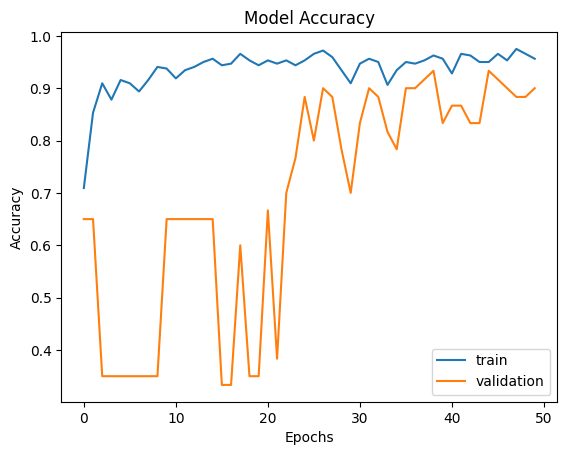

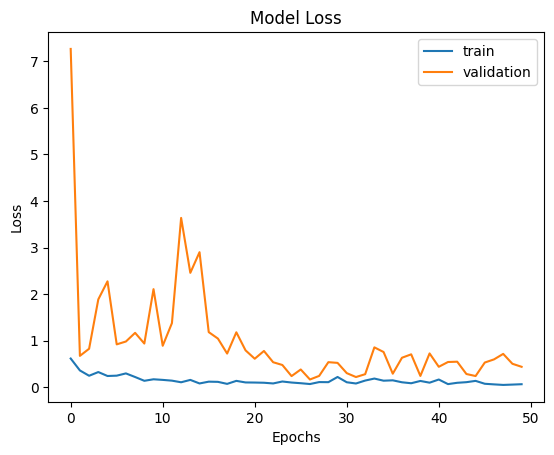

In [63]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [69]:
loss, accuracy = model1.evaluate(X_test, Y_test, verbose=1)
loss_v, accuracy_v = model1.evaluate(x_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
print(len(X_test))
print(len(Y_test))

6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.7479 - loss: 1.3785
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.9021 - loss: 0.5244
Validation: accuracy = 0.900000  ;  loss = 0.441082
Test: accuracy = 0.744444  ;  loss = 1.297031
180
180


In [66]:
lists=[]
y_pred = model1.predict(X_test)
for i in range(len(y_pred)):
    if y_pred[i][0]>0.5:
        lists.append(1)
    else:
        lists.append(0)

print(accuracy_score(Y_test, lists))

6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step
0.7444444444444445


In [67]:
# Python script for confusion matrix creation.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

results = confusion_matrix(Y_test, lists)

print('Confusion Matrix :')
print(results)
print('Accuracy Score :',accuracy_score(Y_test, lists))
print('Report : ')
print(classification_report(Y_test, lists))

Confusion Matrix :
[[43 17]
 [29 91]]
Accuracy Score : 0.7444444444444445
Report : 
              precision    recall  f1-score   support

         0.0       0.60      0.72      0.65        60
         1.0       0.84      0.76      0.80       120

    accuracy                           0.74       180
   macro avg       0.72      0.74      0.72       180
weighted avg       0.76      0.74      0.75       180



[Text(0.5, 1.0, 'Confusion Matrix')]

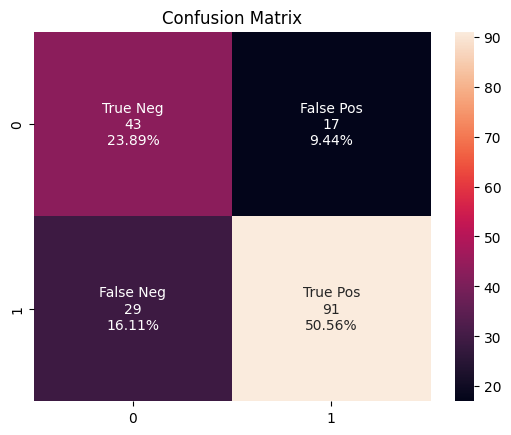

In [68]:
import seaborn as sns
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in results.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in results.flatten()/np.sum(results)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(results, annot=labels, fmt='').set(title="Confusion Matrix")